In [159]:
import matplotlib.pyplot as plt
import numpy as np

file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    # already normalized
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1

x_train = list_image[:, :6000]
y_train = np.asarray(one_hot_encoding(list_label[:6000],10))

x_val = list_image[:, 6000:]
y_val = np.asarray(one_hot_encoding(list_label[6000:],10))

In [160]:
def one_hot_encoding(array, num):
    new_list = []
    for i in array:
        temp_list = [0]*num
        temp_list[i] = 1
        new_list.append(temp_list)
    
    return new_list

def sigmoid(z):
    a = 1 / (1 + np.exp(-z))
    return a

def softmax(z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
        

In [204]:
# Architecture = [785, 197, 50, 10]

class NNA:
    def __init__(self, epochs = 100, lr=0.1, l2=0):
        self.w1 = None
        self.w2 = None
        self.w3 = None
        
        self.a1 = None
        self.a2 = None
        
        self.b1 = None
        self.b2 = None
        self.b3 = None

        self.dw1 = None
        self.dw2 = None
        self.dw3 = None
        
        self.db1 = None
        self.db2 = None
        self.db3 = None
        
        self.loss_history = []
        self.acc_history = []
        self.val_loss_history = []
        self.val_acc_history = []
        
        self.olr = lr
        self.lr = lr
        self.l2 = l2
        self.epochs = epochs
        
    
    def initialize(self):
        self.w1 = np.random.normal(0, 1, (784, 196))
        self.w2 = np.random.normal(0, 1, (196, 49))
        self.w3 = np.random.normal(0, 1, (49, 10))
        
        self.b1 = np.zeros(196)
        self.b2 = np.zeros(49)
        self.b3 = np.zeros(10)
        
    def save_model(self):
        np.savez(f"model_{self.olr}_{self.l2}_{self.epochs}", w1=self.w1, w2=self.w2, w3=self.w3, b1=self.b1, b2 = self.b2, b3 = self.b3)
    
    def load_model(self, path):
        loaded = np.load(path)
        self.w1 = loaded['w1']
        self.w2 = loaded['w2']
        self.w3 = loaded['w3']
        self.b1 = loaded['b1']
        self.b2 = loaded['b2']
        self.b3 = loaded['b3']
    
    def forpass(self, x):
        y = np.dot(x.T, self.w1) + self.b1
        a1 = sigmoid(y)
        self.a1 = a1
        
        z = np.dot(a1, self.w2) + self.b2
        a2 = sigmoid(z)
        self.a2 = a2
        
        f = np.dot(a2, self.w3) + self.b3
        
        return f
    
    def training(self, x, y):
        m = len(x)
        z = self.forpass(x)
        a = softmax(z)
        err = -(y - a)
        self.backprop(x, err)
        
        self.dw1 += self.l2*self.w1 / m
        self.dw2 += self.l2*self.w2 / m
        self.dw3 += self.l2*self.w3 / m
        
        self.w1 -= self.lr * self.dw1
        self.b1 -= self.lr * self.db1
        
        self.w2 -= self.lr * self.dw2
        self.b2 -= self.lr * self.db2
        
        self.w3 -= self.lr * self.dw3
        self.b3 -= self.lr * self.db3
        
        self.lr -= 1/self.epochs * (self.olr)
        
        return a
        
    def backprop(self, x, err):
        m = len(x)
        self.dw3 = np.dot(self.a2.T, err) / m
        self.db3 = np.sum(err) / m
        
        err_hidden = np.dot(err, self.w3.T ) * self.a2 * (1 - self.a2)
        
        self.dw2 = np.dot(self.a1.T, err_hidden) /m
        self.db2 = np.sum(err_hidden, axis=0) /m
        
        err_hidden2 = np.dot(err_hidden, self.w2.T) * self.a1 * ( 1- self.a1)
        
        self.dw1 = np.dot(x, err_hidden2) / m
        self.db1 = np.sum(err_hidden2, axis=0)/m
        
    
    def fit(self, x, y, val_x, val_y):
        m =len(x)
        for i in range(self.epochs):
            a = self.training(x, y)
            a = np.clip(a, 1e-10, 1-1e-10)
            
            loss = np.sum(-y*np.log(a)) + self.l2 / 2 * np.sum(self.w1**2) + self.l2 / 2 * np.sum(self.w2**2) + self.l2 / 2 * np.sum(self.w3**2)
            
            
            z_v = self.forpass(x_val)
            a_v = softmax(z_v)
            a_v = np.clip(a_v, 1e-10, 1-1e-10)
            
            val_loss = np.sum(-y_val*np.log(a_v)) + self.l2 / 2 * np.sum(self.w1**2) + self.l2 / 2 * np.sum(self.w2**2) + self.l2 / 2 * np.sum(self.w3**2)
            
            
            # save accurcay and loss
            self.acc_history.append(np.mean(np.argmax(a, axis=1) == np.argmax(y, axis=1)))
            self.loss_history.append(loss/m)
            self.val_acc_history.append(np.mean(np.argmax(a_v, axis=1) == np.argmax(y_val, axis=1)))
            self.val_loss_history.append(val_loss/m)

    
    # draw loss
    def draw_err(self):
        plt.plot(np.squeeze(self.loss_history), color='b', label='train')
        plt.plot(np.squeeze(self.val_loss_history), color='r', label='test')
        plt.ylabel('loss')            
        plt.xlabel('iterations ')
        plt.legend()
        plt.title("Learning rate =" + str(self.olr))
        plt.show()
    
    # draw accuracy
    def draw_acc(self):
        plt.plot(np.squeeze(self.acc_history), color='b', label='train')
        plt.plot(np.squeeze(self.val_acc_history), color='r', label='test')
        plt.ylabel('accuracy')
        plt.xlabel('iterations ')
        plt.legend()
        plt.title("Learning rate =" + str(self.olr))
        plt.show()
    
    def get_acc(self):
        return self.acc_history[-1]
    def get_val_acc(self):
        return self.val_acc_history[-1]
    def predict(self, x):
        z = self.forpass(x)
        return np.argmax(z, axis=1)
        

In [205]:
net1 = NNA(epochs = 3000, lr = 0.1, l2 = 0.001)

In [206]:
net1.initialize()
net1.fit(x_train, y_train,x_val, y_val)

In [207]:
net1.save_model()

In [191]:
count = 0
correct_index = []
pre = net1.predict(x_val)
for i in range(4000):
    if pre[i] == np.argmax(y_val[i]):
        count+=1
        correct_index.append(i)
    if count == 10:
        break



In [212]:
count = 0
wrong_index = []
pre = net1.predict(x_val)
for i in range(4000):
    if pre[i] != np.argmax(y_val[i]):
        count+=1
        wrong_index.append(i)
    if count == 10:
        break

## 1. Plot the loss curve

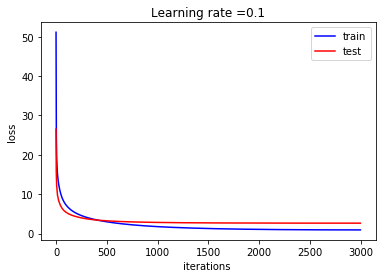

In [208]:
net1.draw_err()

## 2. Plot the accuracy curve

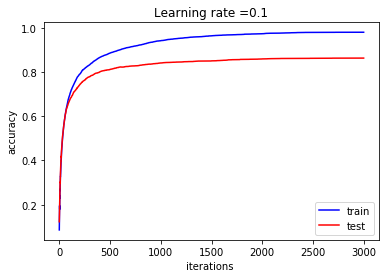

In [209]:
net1.draw_acc()

## 3. Plot the accuracy value

In [210]:
print( f"training accuracy   : {net1.get_acc() * 100}% \nvalidation accuracy : {net1.val_acc_history[-1]*100}%")

training accuracy   : 97.93333333333332% 
validation accuracy : 86.25%


## 4. Plot the classification example

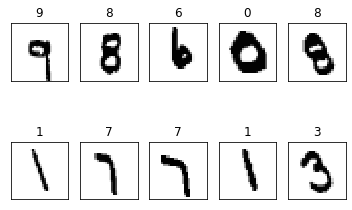

In [211]:
for i in range(10):
    index = correct_index[i]
    label =  np.argmax(y_val[index])
    im_vector = x_val[:, index]
    im_matrix = im_vector.reshape((28, 28))
            
    plt.subplot(2, 5, i+1)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')
            
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

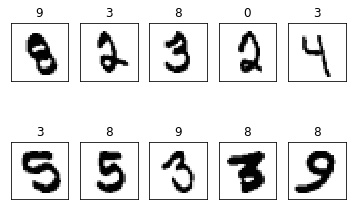

In [213]:
for i in range(10):
    index = wrong_index[i]
    label =  pre[index]
    im_vector = x_val[:, index]
    im_matrix = im_vector.reshape((28, 28))
            
    plt.subplot(2, 5, i+1)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')
            
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)